In [1]:
import joblib 
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
input_dir = '../concats_cut/'
concat_01 = joblib.load(input_dir + 'concat_01.lz4')
y_concat_01 = concat_01['RULR'].values
x_concat_01 = concat_01.drop(columns=['RULR'])

In [3]:
concat_02 = joblib.load(input_dir + 'concat_02.lz4')
y_concat_02 = concat_02['RULR'].values
x_concat_02 = concat_02.drop(columns=['RULR'])
concat_03 = joblib.load(input_dir + 'concat_03.lz4')
y_concat_03 = concat_03['RULR'].values
x_concat_03 = concat_03.drop(columns=['RULR'])

In [33]:
x_concat_01.shape,x_concat_02.shape,x_concat_03.shape

((103367, 39), (100325, 39), (75039, 39))

## 特征选择

#### 1.信息熵过滤

In [35]:
def calc_ent_basis(ser, col):
    """
        描述：
            计算信息熵的方法
    """

    uniq_value_ser = ser.value_counts()
    ser_len = len(ser)
    ent = 0.0
    for val_cnt in uniq_value_ser:
        p = val_cnt / ser_len
        logp = np.log2(p)
        ent -= p * logp
    return {col: ent}
def calc_ent_parallel(df):
    '''
    描述：
        并行计算
    '''
    ent_list = Parallel(n_jobs=48,verbose=1)(delayed(calc_ent_basis)(df.loc[:,col], col) for col in df.columns)
    ent_dict = {}
    for item in ent_list:
        ent_dict.update(item)
    return ent_dict

def ent_filter(df, ent_thred=0.8):
    '''
    描述：
        过滤信息熵小于ent_thred的变量
    '''
    ent_dict = calc_ent_parallel(df)
    ent_ser = pd.Series(ent_dict)
    low_ent_cols = list(ent_ser[ent_ser <= ent_thred].index)
    ent_cols = [col for col in df.columns if col not in low_ent_cols]
    return df[ent_cols], ent_dict

In [57]:
x_concat_01_ent, ent_dict = ent_filter(x_concat_01, 10)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  24 out of  39 | elapsed:    3.0s remaining:    1.8s
[Parallel(n_jobs=48)]: Done  39 out of  39 | elapsed:    3.1s finished


In [66]:
x_concat_01_ent.columns

Index(['CL', 'spindle_load', 'Current_1__abs_energy', 'Current_1__kurtosis',
       'Current_1__mean', 'Current_1__mean_abs_change',
       'Current_1__mean_change', 'Current_1__skewness', 'Current_1__variance',
       'Vibration_1__abs_energy', 'Vibration_1__kurtosis', 'Vibration_1__mean',
       'Vibration_1__mean_abs_change', 'Vibration_1__mean_change',
       'Vibration_1__skewness', 'Vibration_1__variance',
       'Vibration_2__abs_energy', 'Vibration_2__kurtosis', 'Vibration_2__mean',
       'Vibration_2__mean_abs_change', 'Vibration_2__mean_change',
       'Vibration_2__skewness', 'Vibration_2__variance',
       'Vibration_3__abs_energy', 'Vibration_3__kurtosis', 'Vibration_3__mean',
       'Vibration_3__mean_abs_change', 'Vibration_3__mean_change',
       'Vibration_3__skewness', 'Vibration_3__variance',
       'Current_1__abs_energy_scale', 'Vibration_1__abs_energy_scale',
       'Vibration_2__abs_energy_scale', 'Vibration_3__abs_energy_scale'],
      dtype='object')

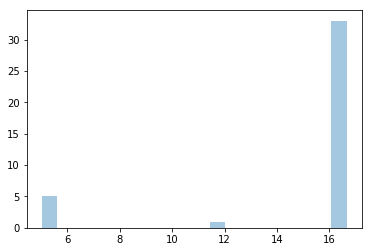

In [59]:
sns.distplot(pd.Series(ent_dict), bins=20, kde=False)

#### 2. 2!排列熵

In [60]:
from pyentrp import entropy as ent

In [72]:
def calc_permutation_ent_basis(order ,ser, col):
    '''
    描述：
        计算序列order阶排序熵
    '''
    pe = ent.permutation_entropy(ser.values, order=order, delay=20000, normalize=True)
    return {col: pe}

def calc_permutation_ent_parallel(df):
    '''
    描述：
        并行计算排序熵
    '''
    pe_list = Parallel(n_jobs=48,verbose=1)(delayed(calc_permutation_ent_basis)(2, df.loc[:,col], col) for col in df.columns)
    pe_dict = {}
    for item in pe_list:
        pe_dict.update(item)
    return pe_dict

def pe_filter(df, pe_thred=1.0):
    '''
    描述：
        过滤排列熵大于等于阈值的变量
    '''
    
    pe_dict = calc_permutation_ent_parallel(df)
    pe_ser = pd.Series(pe_dict)
    high_pe_cols = list(pe_ser[pe_ser >= pe_thred].index)
    pe_cols = [col for col in df.columns if col not in high_pe_cols]
    return df[pe_cols], pe_dict

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   9 out of  34 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=48)]: Done  34 out of  34 | elapsed:    0.1s finished


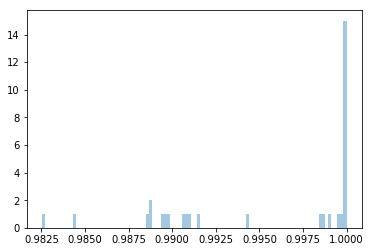

In [73]:
x_concat_01_pe, pe_dict = pe_filter(x_concat_01_ent, 0.999)
sns.distplot(pd.Series(pe_dict)[1:], bins=100, kde=False)

In [74]:
pe_dict

{'CL': -0.0,
 'spindle_load': 0.9942611183830942,
 'Current_1__abs_energy': 0.9999775578555179,
 'Current_1__kurtosis': 0.9999389405270587,
 'Current_1__mean': 0.999979997363446,
 'Current_1__mean_abs_change': 0.9984809518160792,
 'Current_1__mean_change': 0.9999999002576505,
 'Current_1__skewness': 0.9999988988898747,
 'Current_1__variance': 0.9990538121114023,
 'Vibration_1__abs_energy': 0.9914617919042129,
 'Vibration_1__kurtosis': 0.9999891716489355,
 'Vibration_1__mean': 0.9999562830377454,
 'Vibration_1__mean_abs_change': 0.9843812550869301,
 'Vibration_1__mean_change': 0.9999999766472131,
 'Vibration_1__skewness': 0.99993105888046,
 'Vibration_1__variance': 0.990959834190775,
 'Vibration_2__abs_energy': 0.9895479195943457,
 'Vibration_2__kurtosis': 0.9999969650696995,
 'Vibration_2__mean': 0.9999357146353502,
 'Vibration_2__mean_abs_change': 0.9825478283175533,
 'Vibration_2__mean_change': 0.9999870667728628,
 'Vibration_2__skewness': 0.9996201393947796,
 'Vibration_2__variance'

In [75]:
def box_filter(x):
    '''
    描述：
        箱线图去异常值，x为array
    '''
    x = x.copy()
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    low_bound = q1 - 15*iqr
    up_bound = q3 + 15*iqr
    x[x<low_bound] = low_bound
    x[x>up_bound] = up_bound
    return x 


def plot_feature_trend(df, apply_cols):
    for col in apply_cols:
        plt.figure()
        plt.plot(box_filter(df[col]))
        plt.title(col)

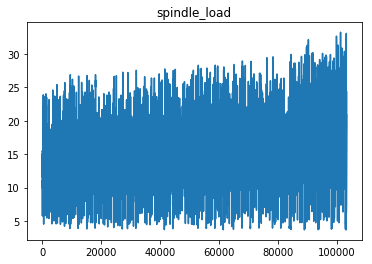

In [76]:
plot_feature_trend(x_concat_01, apply_cols=['spindle_load'])

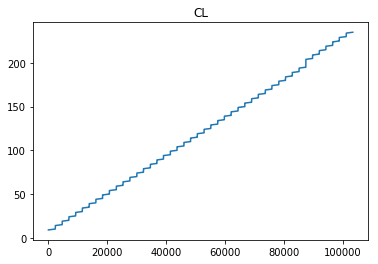

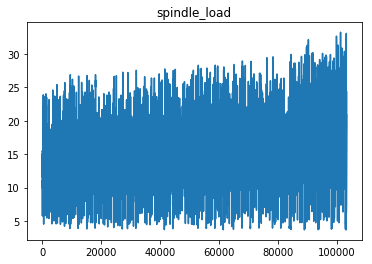

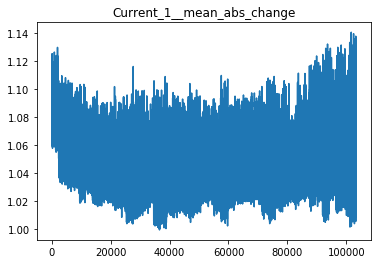

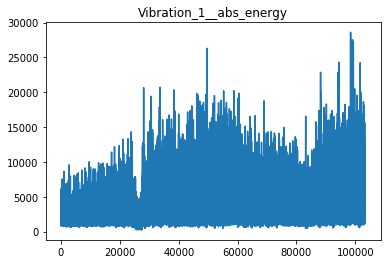

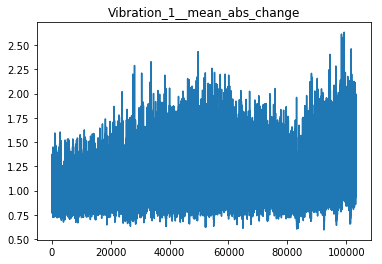

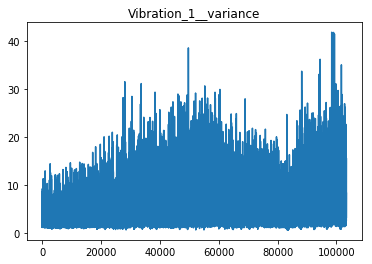

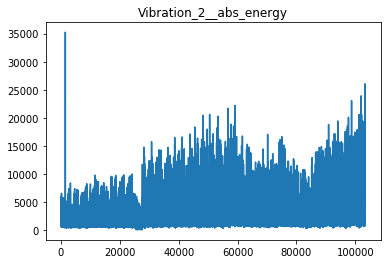

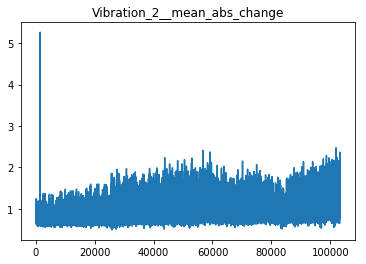

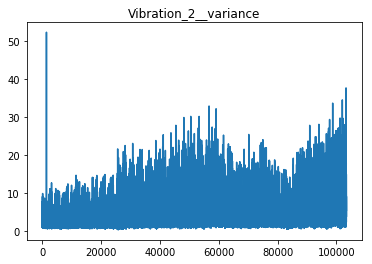

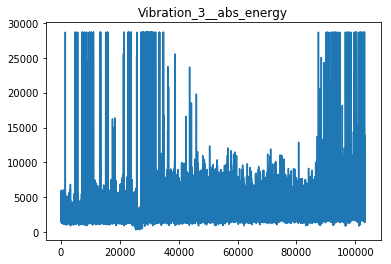

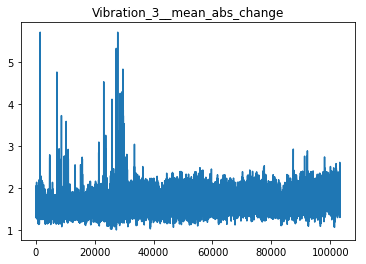

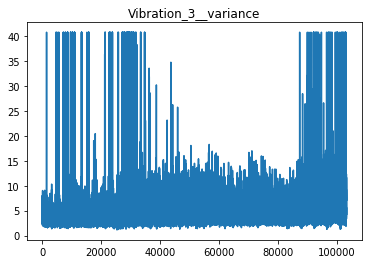

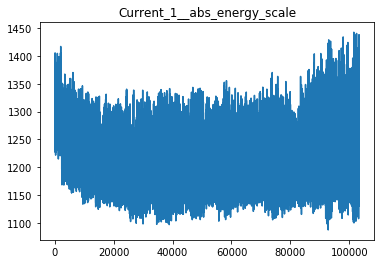

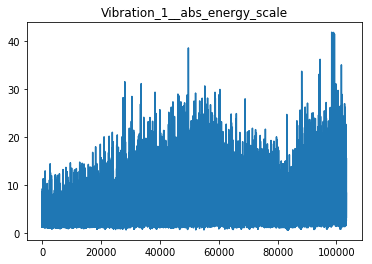

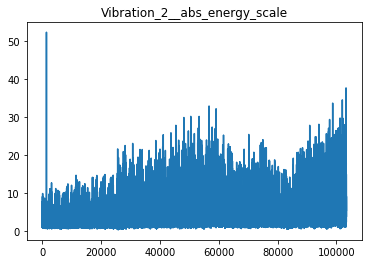

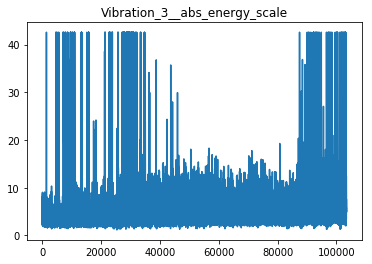

In [77]:
plot_feature_trend(x_concat_01_pe, apply_cols=list(x_concat_01_pe.columns))

## 构建health indicator（3步骤）

#### 1.variable compression

In [78]:
from sklearn.decomposition import PCA

In [79]:
pca = PCA(n_components=1, whiten=True)
pca.fit(x_concat_01_pe.drop(columns=['CL']).values)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [80]:
compressed_var = pca.transform(x_concat_01_pe.drop(columns=['CL']).values)

In [81]:
compressed_var = compressed_var.reshape(-1)

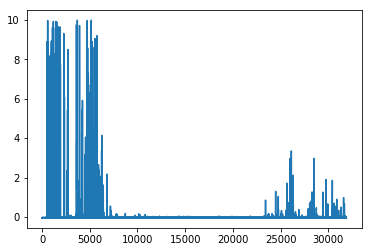

In [82]:
filter_var = compressed_var[(-0.05<compressed_var)&(compressed_var<10)]
plt.plot(filter_var)

#### 2.trend extraction

In [83]:
from pyhht.visualization import plot_imfs
from pyhht.emd import EMD

In [84]:
decomposer = EMD(filter_var, n_imfs=10, maxiter=100)

In [85]:
imfs = decomposer.decompose()

2


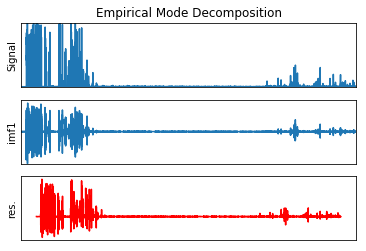

In [86]:
plot_imfs(filter_var, imfs)